In [2]:
import pandas as pd

In [3]:
# Cargar los datos
car_data = pd.read_csv('datasets/vehicle_dataset/car_data.csv')
car_dekho = pd.read_csv('datasets/vehicle_dataset/CAR_DETAILS_FROM_CAR_DEKHO.csv')
car_v3 = pd.read_csv('datasets/vehicle_dataset/Car_details_v3.csv')
car_v4 = pd.read_csv('datasets/vehicle_dataset/car_details_v4.csv')

Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario. 

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import re
from datetime import datetime
import os

# Function to show information about the dataset
def dataset_info(df):
    print(f"Dimensiones: {df.shape}")
    print(f"Valores faltantes: {df.isnull().sum().sum()}")
    print(f"Duplicados: {df.duplicated().sum()}")
    print("\nResumen de datos numéricos:")
    print(df.describe().T)
    print("\nPrimeras filas:")
    print(df.head())

# Verify each dataset
for name, df in [("car_data", car_data), 
                ("car_dekho", car_dekho), 
                ("car_v3", car_v3), 
                ("car_v4", car_v4)]:
    print(f"\n{'='*50}\nAnálisis del dataset: {name}\n{'='*50}")
    dataset_info(df)


Análisis del dataset: car_data
Dimensiones: (301, 9)
Valores faltantes: 0
Duplicados: 2

Resumen de datos numéricos:
               count          mean           std      min      25%      50%  \
Year           301.0   2013.627907      2.891554  2003.00   2012.0   2014.0   
Selling_Price  301.0      4.661296      5.082812     0.10      0.9      3.6   
Present_Price  301.0      7.628472      8.644115     0.32      1.2      6.4   
Kms_Driven     301.0  36947.205980  38886.883882   500.00  15000.0  32000.0   
Owner          301.0      0.043189      0.247915     0.00      0.0      0.0   

                   75%       max  
Year            2016.0    2018.0  
Selling_Price      6.0      35.0  
Present_Price      9.9      92.6  
Kms_Driven     48767.0  500000.0  
Owner              0.0       3.0  

Primeras filas:
  Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75     

In [6]:
def clean_dataset(df, dataset_name):
    """Clean and preprocess a dataset based on its specific characteristics"""
    print(f"Processing {dataset_name}...")
    
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # 1. Normalize column names (lowercase, no spaces)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # 2. Dataset-specific handling
    if dataset_name == "car_data":
        # Convert categorical columns to lowercase
        for col in ['car_name', 'fuel_type', 'seller_type', 'transmission']:
            if col in df.columns:
                df[col] = df[col].str.lower()
        
    elif dataset_name == "car_dekho":
        # Convert categorical columns to lowercase
        for col in ['name', 'fuel', 'seller_type', 'transmission']:
            if col in df.columns:
                df[col] = df[col].str.lower()
        
        # Standardize owner column
        if 'owner' in df.columns:
            owner_mapping = {
                'First Owner': 'first_owner',
                'Second Owner': 'second_owner',
                'Third Owner': 'third_owner',
                'Fourth & Above Owner': 'fourth_plus_owner'
            }
            df['owner'] = df['owner'].replace(owner_mapping)
    
    elif dataset_name == "car_v3":
        # Convert categorical columns to lowercase
        for col in ['name', 'fuel', 'seller_type', 'transmission', 'owner']:
            if col in df.columns and df[col].dtype == 'object':
                df[col] = df[col].str.lower()
        
        # Extract numeric values from text columns
        if 'mileage' in df.columns:
            df['mileage_value'] = df['mileage'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
            df['mileage_unit'] = df['mileage'].str.extract(r'([a-zA-Z/]+)')
        
        if 'engine' in df.columns:
            df['engine_cc'] = df['engine'].str.extract(r'(\d+)').astype(float)
        
        if 'max_power' in df.columns:
            df['power_bhp'] = df['max_power'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
    
    elif dataset_name == "car_v4":
        # Clean categorical columns
        cat_cols = df.select_dtypes(include=['object']).columns
        for col in cat_cols:
            df[col] = df[col].str.lower() if hasattr(df[col], 'str') else df[col]
        
        # Extract numeric values from max_power and max_torque
        if 'max_power' in df.columns:
            df['power_bhp'] = df['max_power'].str.extract(r'(\d+\.?\d*)').astype(float)
        
        if 'max_torque' in df.columns:
            df['torque_nm'] = df['max_torque'].str.extract(r'(\d+\.?\d*)').astype(float)
        
        # Convert dimensions to consistent units
        for dim in ['length', 'width', 'height']:
            if dim in df.columns:
                df[dim] = pd.to_numeric(df[dim], errors='coerce')
    
    # 3. Handle missing values (common for all datasets)
    # For numeric columns, fill with median
    num_cols = df.select_dtypes(include=['number']).columns
    for col in num_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns, fill with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df[col].isnull().any():
            if not df[col].mode().empty:
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                df[col] = df[col].fillna("unknown")
    
    # 4. Remove duplicates
    df_deduped = df.drop_duplicates()
    print(f"Removed {df.shape[0] - df_deduped.shape[0]} duplicate rows")
    df = df_deduped
    
    # 5. Ensure correct data types
    if 'year' in df.columns:
        df['year'] = df['year'].astype(int)
    
    return df

In [7]:
# Process each dataset
car_data_clean = clean_dataset(car_data, "car_data")
car_dekho_clean = clean_dataset(car_dekho, "car_dekho")
car_v3_clean = clean_dataset(car_v3, "car_v3")
car_v4_clean = clean_dataset(car_v4, "car_v4")

# Verify each processed dataset
for name, df in [("car_data_clean", car_data_clean), 
                ("car_dekho_clean", car_dekho_clean), 
                ("car_v3_clean", car_v3_clean), 
                ("car_v4_clean", car_v4_clean)]:
    print(f"\n{'='*50}\nAnálisis del dataset procesado: {name}\n{'='*50}")
    dataset_info(df)

# Save processed datasets
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

car_data_clean.to_csv(f"{output_dir}/car_data_clean.csv", index=False)
car_dekho_clean.to_csv(f"{output_dir}/car_dekho_clean.csv", index=False)
car_v3_clean.to_csv(f"{output_dir}/car_v3_clean.csv", index=False)
car_v4_clean.to_csv(f"{output_dir}/car_v4_clean.csv", index=False)

print(f"\nProcessed files saved to {output_dir}/")

Processing car_data...
Removed 2 duplicate rows
Processing car_dekho...
Removed 763 duplicate rows
Processing car_v3...
Removed 1202 duplicate rows
Processing car_v4...
Removed 0 duplicate rows

Análisis del dataset procesado: car_data_clean
Dimensiones: (299, 9)
Valores faltantes: 0
Duplicados: 0

Resumen de datos numéricos:
               count          mean           std      min       25%       50%  \
year           299.0   2013.615385      2.896868  2003.00   2012.00   2014.00   
selling_price  299.0      4.589632      4.984240     0.10      0.85      3.51   
present_price  299.0      7.541037      8.567887     0.32      1.20      6.10   
kms_driven     299.0  36916.752508  39015.170352   500.00  15000.00  32000.00   
owner          299.0      0.043478      0.248720     0.00      0.00      0.00   

                    75%       max  
year            2016.00    2018.0  
selling_price      6.00      35.0  
present_price      9.84      92.6  
kms_driven     48883.50  500000.0  
owner


Visualizing car_data...


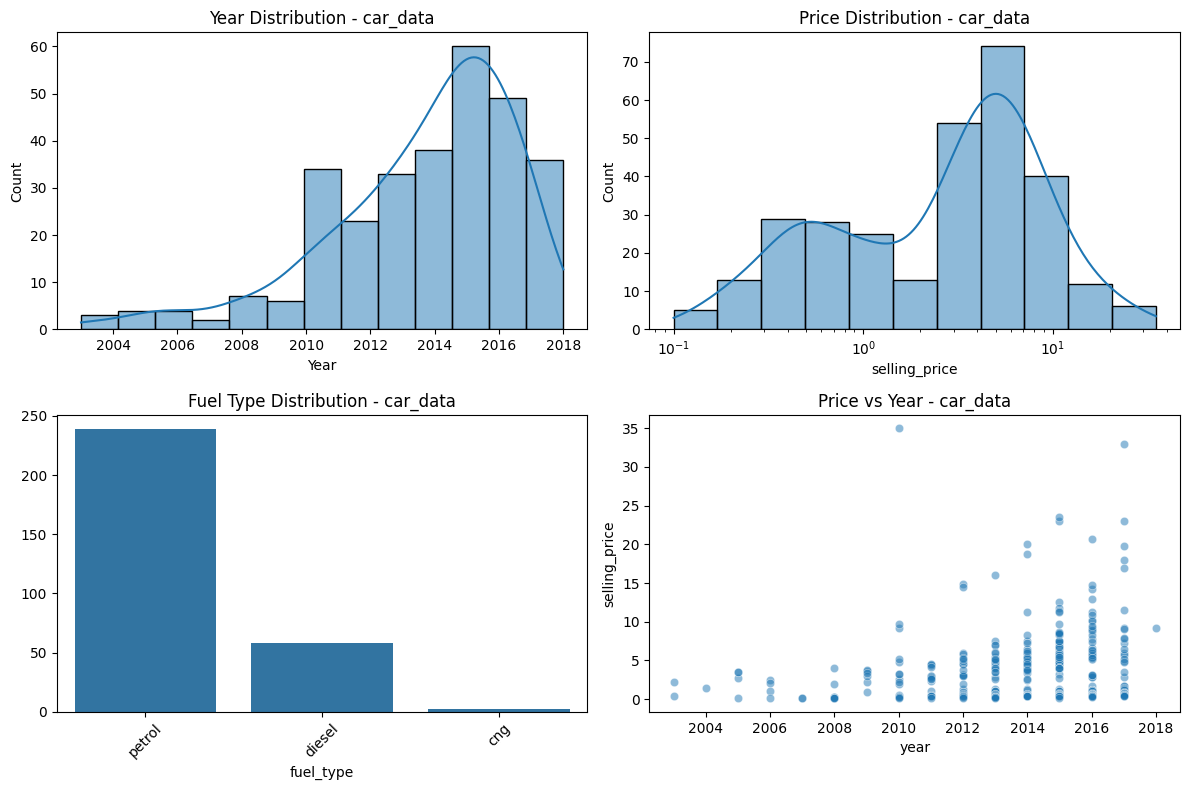


Visualizing car_dekho...


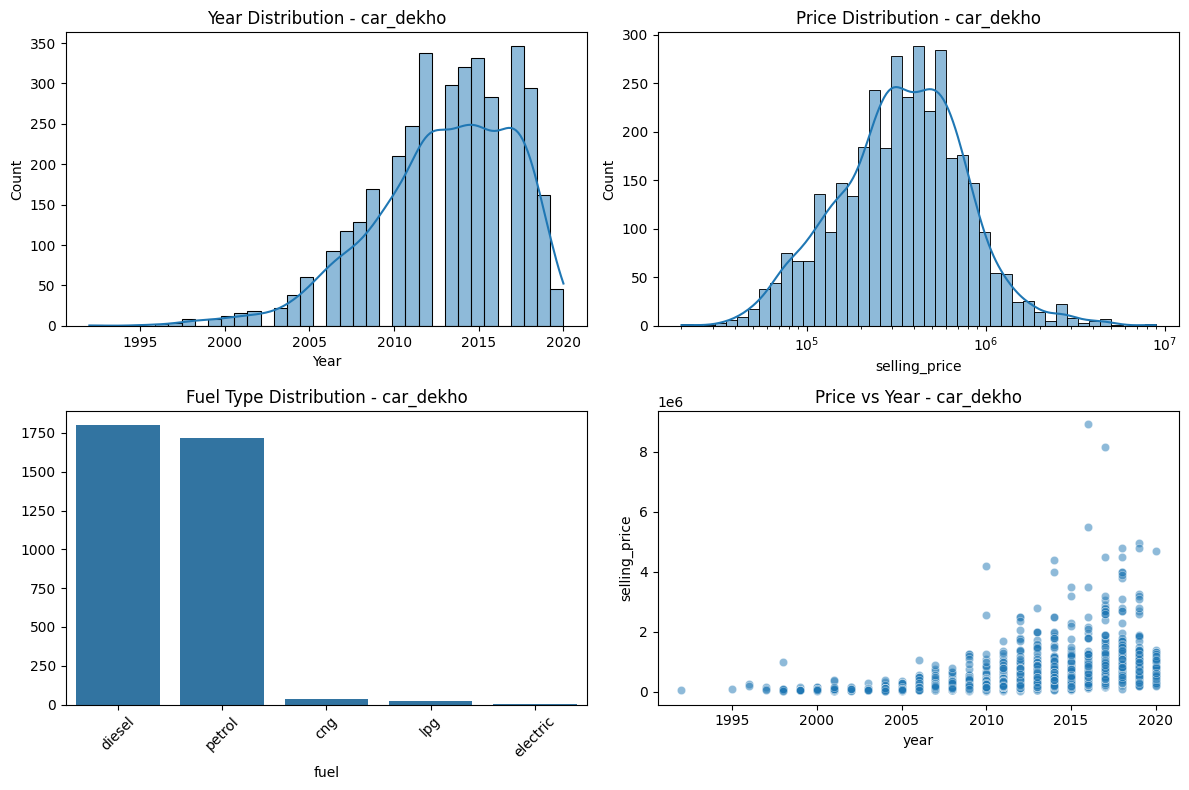


Visualizing car_v3...


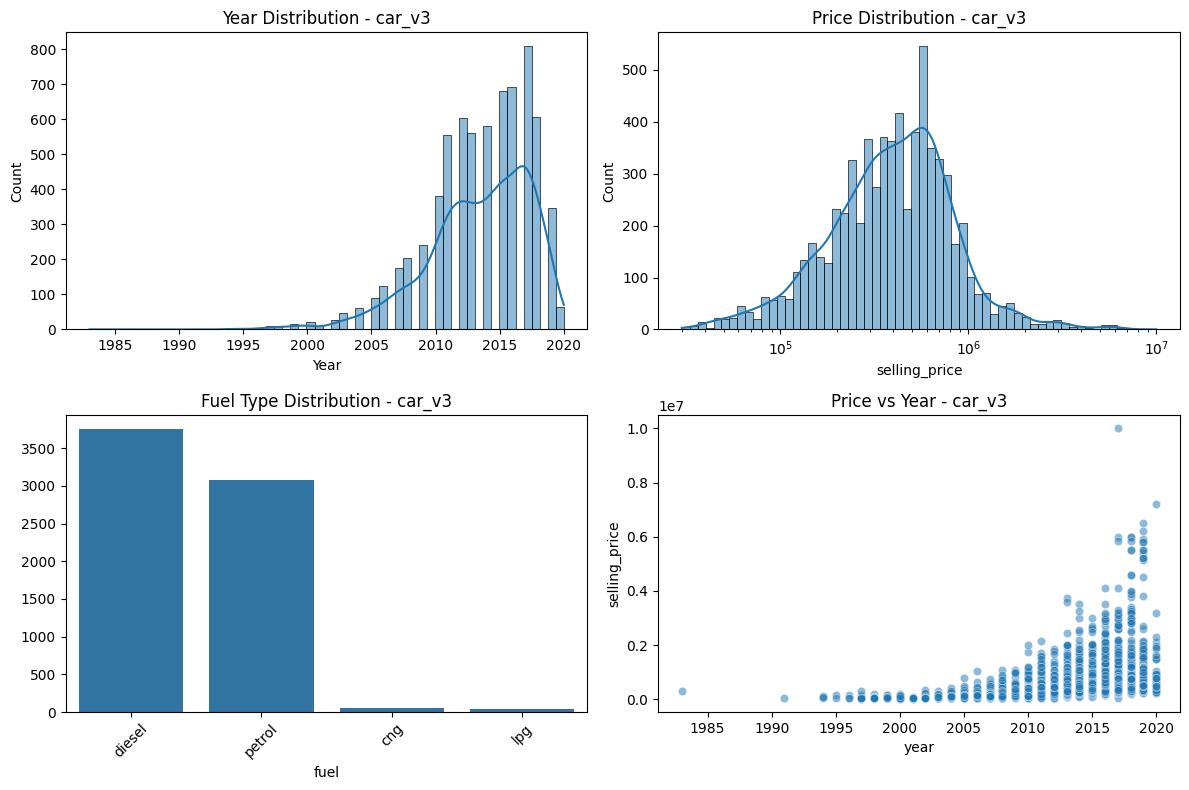


Visualizing car_v4...


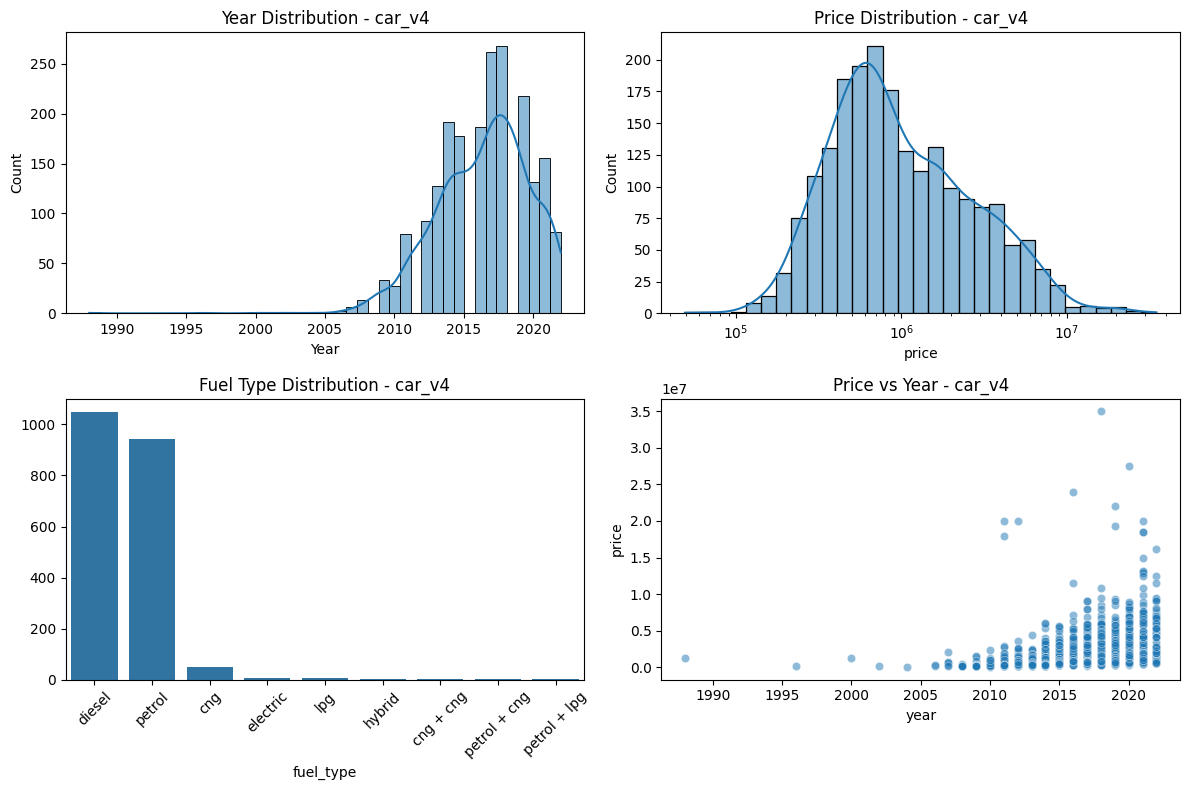

In [8]:
def visualize_data(df, dataset_name):
    """Create basic visualizations for the cleaned dataset"""
    print(f"\nVisualizing {dataset_name}...")
    
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Year distribution
    if 'year' in df.columns:
        plt.subplot(2, 2, 1)
        sns.histplot(df['year'], kde=True)
        plt.title(f'Year Distribution - {dataset_name}')
        plt.xlabel('Year')
    
    # Plot 2: Price distribution
    price_col = [col for col in df.columns if 'price' in col.lower() and df[col].dtype != 'object']
    if price_col:
        plt.subplot(2, 2, 2)
        sns.histplot(df[price_col[0]].dropna(), kde=True, log_scale=True)
        plt.title(f'Price Distribution - {dataset_name}')
        plt.xlabel(price_col[0])
    
    # Plot 3: Fuel type distribution
    fuel_col = [col for col in df.columns if 'fuel' in col.lower() and df[col].dtype == 'object']
    if fuel_col:
        plt.subplot(2, 2, 3)
        fuel_counts = df[fuel_col[0]].value_counts()
        sns.barplot(x=fuel_counts.index, y=fuel_counts.values)
        plt.title(f'Fuel Type Distribution - {dataset_name}')
        plt.xticks(rotation=45)
        plt.xlabel(fuel_col[0])
    
    # Plot 4: Price vs Year scatter plot
    if 'year' in df.columns and price_col:
        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x='year', y=price_col[0], alpha=0.5)
        plt.title(f'Price vs Year - {dataset_name}')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{dataset_name}_visualization.png")
    plt.show()

# Create visualizations for each cleaned dataset
for name, df in [("car_data", car_data_clean), 
                ("car_dekho", car_dekho_clean), 
                ("car_v3", car_v3_clean), 
                ("car_v4", car_v4_clean)]:
    visualize_data(df, name)